<a href="https://colab.research.google.com/github/aditeyabaral/kepler-exoplanet-analysis/blob/master/src/Prediction_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, cohen_kappa_score, f1_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# Loading Dataframe

In [2]:
df = pd.read_csv("../data/[CLEANED]kepler-data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(9110, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Selecting Columns for Prediction

In [3]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [4]:
print(len(TO_USE))
df[TO_USE].head()

19


,koi_impact,koi_fpflag_ss,koi_kepmag,koi_model_snr,koi_duration,koi_fpflag_ec,koi_prad,koi_insol,ra,koi_slogg,koi_srad,koi_teq,koi_steff,koi_fpflag_co,dec,koi_period,koi_time0bk,koi_fpflag_nt,koi_depth
0,0.146,0,15.347,35.8,2.95750,0,2.26,93.59,291.93423,4.467,0.927,793.0,5455.0,0,48.141651,9.488036,170.538750,0,615.8
1,0.586,0,15.347,25.8,4.50700,0,2.83,9.11,291.93423,4.467,0.927,443.0,5455.0,0,48.141651,54.418383,162.513840,0,874.8
2,0.969,1,15.436,76.3,1.78220,0,14.60,39.30,297.00482,4.544,0.868,638.0,5853.0,0,48.134129,19.899140,175.850252,0,10829.0
3,1.276,1,15.597,505.6,2.40641,0,33.46,891.96,285.53461,4.564,0.791,1395.0,5805.0,0,48.285210,1.736952,170.307565,0,8079.2
4,0.701,0,15.509,40.9,1.65450,0,2.75,926.16,288.75488,4.438,1.046,1406.0,6031.0,0,48.226200,2.525592,171.595550,0,603.3


# Extracting Dataframe Subset

We extract only those rows which are either positive or negative examples i.e. the `disposition value` is *not* `CANDIDATE`

In [5]:
subset_df = df[df["koi_disposition"] != "CANDIDATE"]
print(subset_df.shape)
subset_df.head()

(6939, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Obtaining X and y

We also need to encode the categorical labels
```
CONFIRMED - 1
FALSE POSITIVE - 0
```

In [6]:
X = subset_df[TO_USE].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [7]:
subset_df["koi_disposition"].value_counts()

FALSE POSITIVE    4647
CONFIRMED         2292
Name: koi_disposition, dtype: int64

# PCA Visualisation

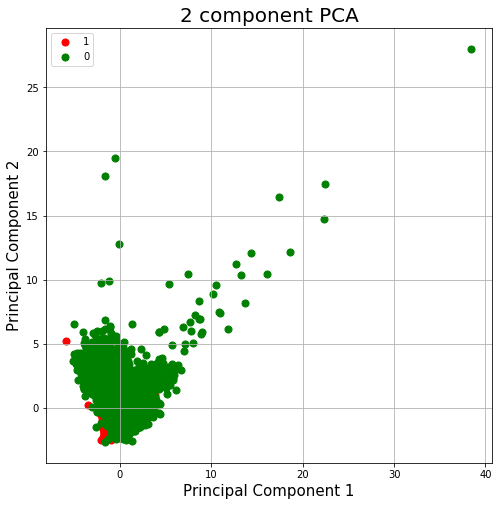

In [8]:
x = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf["TARGET"] = y
finalDf = principalDf
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 0]
# print(finalDf)

colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['TARGET'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

# Splitting into Train and Test sets

In [37]:
#X = StandardScaler().fit_transform(X)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [39]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4649, 19), (2290, 19), (4649,), (2290,))

# Defining Evaluation Metric 

Since the dataset is imbalanced, we cannot use accuracy, hence we opt for either of the following -
* Confusion Matrix
* F1 Score
* Cohen Kappa Score
* Balanced Accuracy Score

In [40]:
def performance(test, pred):
    conf_matrix = confusion_matrix(test, pred)
    f1 = f1_score(test, pred)
    report = classification_report(test, pred)
    accuracy = balanced_accuracy_score(test, pred)
    kappa = cohen_kappa_score(test, pred)
    print(f"F1 Score: {f1}")
    print(f"Kappa Score: {kappa}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

# To-Do

* Cross Validation
* Hyperparameter Tuning
* Feature Selection

# Decision Tree

In [41]:
# baseline model
classifier = DecisionTreeClassifier(random_state=0)
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

In [42]:
performance(y_test, pred)

F1 Score: 0.9550408719346049
Kappa Score: 0.9338328774511693
Accuracy Score: 0.9662485661126965
Confusion Matrix:
[[1523   31]
 [  35  701]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1554
           1       0.96      0.95      0.96       736

    accuracy                           0.97      2290
   macro avg       0.97      0.97      0.97      2290
weighted avg       0.97      0.97      0.97      2290



In [43]:
#tree.plot_tree(classifier, filled=True)
dot_tree = tree.export_graphviz(
    classifier,
    feature_names=subset_df[TO_USE].columns,  
    class_names=np.unique(subset_df["koi_disposition"].values),  
    filled=True, rounded=True,  
    special_characters=True
)
graph = graphviz.Source(dot_tree) 
graph.render("Decision Tree")
#graph

'Decision Tree.pdf'

In [44]:
"""text_graph = tree.export_text(
    classifier,
    feature_names=subset_df[TO_USE].columns.tolist()
)
print(text_graph)"""

'text_graph = tree.export_text(\n    classifier,\n    feature_names=subset_df[TO_USE].columns.tolist()\n)\nprint(text_graph)'

## Hyperparameter Tuning for Decision Tree

In [45]:
parameters = {
    #"criterion":["gini", "entropy"],
    "splitter":["best", "random"],
    #"max_depth":[None] + np.linspace(1, 32, 32, endpoint=True).tolist(),
    "min_samples_split":np.linspace(0, 1, 11, endpoint=True),
    "min_samples_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    #"max_features":[None] + list(range(1,X_train.shape[1])),
    "min_weight_fraction_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    "random_state":[0],
    "min_impurity_decrease":np.linspace(0, 1, 10, endpoint=True),
    "class_weight":[None, "balanced"],
    #"max_leaf_nodes":[None] + np.linspace(1, 25, 25, endpoint=True).tolist(),
    "ccp_alpha":np.linspace(0, 10, 11, endpoint=True)
}

scores = ["f1", "balanced_accuracy"]

In [46]:
"""classifier = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=parameters,
    scoring=scores,
    refit=False,
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)"""

'classifier = GridSearchCV(\n    DecisionTreeClassifier(),\n    param_grid=parameters,\n    scoring=scores,\n    refit=False,\n    verbose=1,\n    n_jobs=-1\n)\n\nclassifier.fit(X_train, y_train)'

# Random Forest

In [47]:
# baseline model
classifier = RandomForestClassifier(random_state=0, n_jobs=-1, verbose=1)
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [48]:
performance(y_test, pred)

F1 Score: 0.9728978457261988
Kappa Score: 0.9604909369367934
Accuracy Score: 0.9745782272956186
Confusion Matrix:
[[1551    3]
 [  36  700]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1554
           1       1.00      0.95      0.97       736

    accuracy                           0.98      2290
   macro avg       0.99      0.97      0.98      2290
weighted avg       0.98      0.98      0.98      2290



## Hyperparameter Tuning for Random  Forest

In [49]:
parameters = {
    "n_estimators":np.arange(100,500,20),
    #"criterion":["gini", "entropy"],
    #"max_depth":[None] + np.linspace(1, 32, 32, endpoint=True).tolist(),
    #"min_samples_split":np.linspace(0, 1, 11, endpoint=True),
    #"min_samples_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    #"max_features":[None] + list(range(1,X_train.shape[1])),
    #"min_weight_fraction_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    "random_state":[0],
    #"oob_score":[True, False],
    #"min_impurity_decrease":np.linspace(0, 1, 10, endpoint=True),
    #"class_weight":[None, "balanced", "balanced_subsample"],
    #"warm_start":[True, False],
    #"max_leaf_nodes":[None] + np.linspace(1, 25, 25, endpoint=True).tolist(),
    #"ccp_alpha":np.linspace(0, 10, 11, endpoint=True)
}

scores = ["f1", "balanced_accuracy"]

In [50]:
"""classifier = GridSearchCV(
    RandomForestClassifier(),
    param_grid=parameters,
    scoring=scores,
    refit=False,
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)"""

'classifier = GridSearchCV(\n    RandomForestClassifier(),\n    param_grid=parameters,\n    scoring=scores,\n    refit=False,\n    verbose=1,\n    n_jobs=-1\n)\n\nclassifier.fit(X_train, y_train)'

# XGBoost

In [51]:
# baseline model
classifier = XGBClassifier(random_state=0, n_jobs=-1)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
pred = classifier.predict(X_test)
performance(y_test, pred)

F1 Score: 0.9730476848652385
Kappa Score: 0.9606049832424511
Accuracy Score: 0.9760086173129652
Confusion Matrix:
[[1547    7]
 [  32  704]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1554
           1       0.99      0.96      0.97       736

    accuracy                           0.98      2290
   macro avg       0.98      0.98      0.98      2290
weighted avg       0.98      0.98      0.98      2290



## Hyperparameter Tuning for XGBoost

In [53]:
parameters = {
    "n_estimators":np.arange(100,500,20),
    #"criterion":["gini", "entropy"],
    #"max_depth":[None] + np.linspace(1, 32, 32, endpoint=True).tolist(),
    #"min_samples_split":np.linspace(0, 1, 11, endpoint=True),
    #"min_samples_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    #"max_features":[None] + list(range(1,X_train.shape[1])),
    #"min_weight_fraction_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    "random_state":[0],
    #"oob_score":[True, False],
    #"min_impurity_decrease":np.linspace(0, 1, 10, endpoint=True),
    #"class_weight":[None, "balanced", "balanced_subsample"],
    #"warm_start":[True, False],
    #"max_leaf_nodes":[None] + np.linspace(1, 25, 25, endpoint=True).tolist(),
    #"ccp_alpha":np.linspace(0, 10, 11, endpoint=True)
}

scores = ["f1", "balanced_accuracy"]

In [54]:
"""classifier = GridSearchCV(
    XGBClassifier(),
    param_grid=parameters,
    scoring=scores,
    refit=False,
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)"""

'classifier = GridSearchCV(\n    XGBClassifier(),\n    param_grid=parameters,\n    scoring=scores,\n    refit=False,\n    verbose=1,\n    n_jobs=-1\n)\n\nclassifier.fit(X_train, y_train)'

# Gradient Boosting Classifier

In [55]:
# baseline model
classifier = GradientBoostingClassifier(random_state=0)
classifier.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [56]:
pred = classifier.predict(X_test)
performance(y_test, pred)

F1 Score: 0.9751381215469612
Kappa Score: 0.9636484856181344
Accuracy Score: 0.9776890632868893
Confusion Matrix:
[[1548    6]
 [  30  706]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1554
           1       0.99      0.96      0.98       736

    accuracy                           0.98      2290
   macro avg       0.99      0.98      0.98      2290
weighted avg       0.98      0.98      0.98      2290



## Hyperparameter Tuning for GBC

In [57]:
parameters = {
    "n_estimators":np.arange(100,500,20),
    #"criterion":["gini", "entropy"],
    #"max_depth":[None] + np.linspace(1, 32, 32, endpoint=True).tolist(),
    #"min_samples_split":np.linspace(0, 1, 11, endpoint=True),
    #"min_samples_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    #"max_features":[None] + list(range(1,X_train.shape[1])),
    #"min_weight_fraction_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    "random_state":[0],
    #"oob_score":[True, False],
    #"min_impurity_decrease":np.linspace(0, 1, 10, endpoint=True),
    #"class_weight":[None, "balanced", "balanced_subsample"],
    #"warm_start":[True, False],
    #"max_leaf_nodes":[None] + np.linspace(1, 25, 25, endpoint=True).tolist(),
    #"ccp_alpha":np.linspace(0, 10, 11, endpoint=True)
}

scores = ["f1", "balanced_accuracy"]

In [58]:
"""classifier = GridSearchCV(
    GradientBoostingClassifier(),
    param_grid=parameters,
    scoring=scores,
    refit=False,
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)"""

'classifier = GridSearchCV(\n    GradientBoostingClassifier(),\n    param_grid=parameters,\n    scoring=scores,\n    refit=False,\n    verbose=1,\n    n_jobs=-1\n)\n\nclassifier.fit(X_train, y_train)'

# Adaboost

In [59]:
# baseline model
classifier = AdaBoostClassifier(random_state=0)
classifier.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=0)

In [60]:
pred = classifier.predict(X_test)
performance(y_test, pred)

F1 Score: 0.9717825189263591
Kappa Score: 0.9586741938408747
Accuracy Score: 0.9760803116781378
Confusion Matrix:
[[1543   11]
 [  30  706]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1554
           1       0.98      0.96      0.97       736

    accuracy                           0.98      2290
   macro avg       0.98      0.98      0.98      2290
weighted avg       0.98      0.98      0.98      2290



## Hyperparameter Tuning for AdaBoost

In [61]:
parameters = {
    "n_estimators":np.arange(100,500,20),
    #"criterion":["gini", "entropy"],
    #"max_depth":[None] + np.linspace(1, 32, 32, endpoint=True).tolist(),
    #"min_samples_split":np.linspace(0, 1, 11, endpoint=True),
    #"min_samples_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    #"max_features":[None] + list(range(1,X_train.shape[1])),
    #"min_weight_fraction_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    "random_state":[0],
    #"oob_score":[True, False],
    #"min_impurity_decrease":np.linspace(0, 1, 10, endpoint=True),
    #"class_weight":[None, "balanced", "balanced_subsample"],
    #"warm_start":[True, False],
    #"max_leaf_nodes":[None] + np.linspace(1, 25, 25, endpoint=True).tolist(),
    #"ccp_alpha":np.linspace(0, 10, 11, endpoint=True)
}

scores = ["f1", "balanced_accuracy"]

In [62]:
"""classifier = GridSearchCV(
    AdaBoostClassifier(),
    param_grid=parameters,
    scoring=scores,
    refit=False,
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)"""

'classifier = GridSearchCV(\n    AdaBoostClassifier(),\n    param_grid=parameters,\n    scoring=scores,\n    refit=False,\n    verbose=1,\n    n_jobs=-1\n)\n\nclassifier.fit(X_train, y_train)'